# Scalar Quantisation

Try to understand optimal scalar quantisation for artificial iid data. Based heavily on the lecture slides [Optimal Scalar Quantisation](https://iphome.hhi.de/schwarz/assets/dc/10-OptScalarQuant.pdf), Heiko Schwarz.

We will:
 - Build fixed-length coding quantisers
   - Scaled INT
   - Non-linear via Lloyd-Max
 - Build variable-length coding quantisers
   - Entropy-coded Uniform
   - Uniform Reconstruction Quantisation (URQ)
   - Entropy-Constrained Scalar Quantisation (ECSQ)
 - Test their efficiency on iid samples

### Setup & Data

In [22]:
from dataclasses import dataclass
from functools import partial
import itertools as it
import math
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import Tensor, tensor
from typing import Any, Callable
import scipy.optimize
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False, "figure.figsize": (4, 3)})

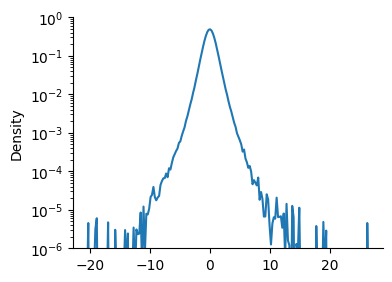

In [2]:
df = tensor(5.0)
n_samples = 2**20
torch.manual_seed(100)

data = torch.distributions.StudentT(df, scale=(df - 2).div(df).sqrt()).sample((n_samples,))
ax = sns.kdeplot(data.cpu())
ax.set_yscale("log")
ax.set_ylim((10**-6, 1));

### Common

In [3]:
@dataclass
class Quantiser:
    codepoints: Tensor  # (n)
    thresholds: Tensor  # (n-1)
    lengths: Tensor     # (n)

    @classmethod
    def fixed_length(cls, codepoints: Tensor) -> "Quantiser":
        return cls(
            codepoints=codepoints,
            thresholds=(codepoints[1:] + codepoints[:-1]) / 2,
            lengths=torch.full_like(codepoints, math.log2(codepoints.nelement()))
        )

    def quantise(self, data: Tensor) -> Tensor:
        return self.codepoints[torch.bucketize(data, self.thresholds)]

    def bits_per_element(self, data: Tensor) -> float:
        return self.lengths[torch.bucketize(data, self.thresholds)].mean()


def rmse_norm(data: Tensor, quantiser: Quantiser) -> Tensor:
    data_rms = data.pow(2).mean().sqrt()
    error_rms = (data - quantiser.quantise(data)).pow(2).mean().sqrt()
    return error_rms / data_rms


def tradeoff(data: Tensor, factory: Callable[[Tensor, Tensor], Quantiser], args: Tensor) -> tuple[Tensor, Tensor]:
    bits, error = torch.empty((2, args.shape[0]), device="cpu")
    for i, arg in enumerate(args):
        q = factory(data, arg)
        bits[i] = q.bits_per_element(data)
        error[i] = rmse_norm(data, q)
    return bits, error


def show(quantiser: Quantiser, ax: matplotlib.axes.Axes | None = None) -> matplotlib.axes.Axes:
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 0.5))
    ax.scatter(quantiser.codepoints.cpu(), torch.full_like(quantiser.codepoints.cpu(), 0.0), color="b")
    for x in quantiser.thresholds.cpu():
        ax.axvline(x, color="k", lw=0.5)
    ax.set_yticks([])
    ax.spines["left"].set_visible(False)
    return ax

### Scaled-INT

error = 0.286
 bits = 3.000


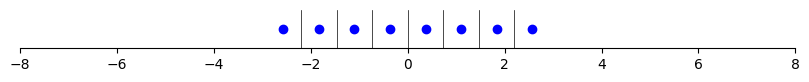

In [39]:
def scaled_int(data: Tensor, bits: Tensor) -> Quantiser:
    base_centroids = torch.arange(2**bits) - 2**(bits-1) + 0.5
    base_thresholds = torch.arange(2**bits-1) - 2**(bits-1) + 1
    # Explicit search (lazy solution)
    delta_max = data.abs().amax().div(base_centroids[-1]).item()
    def error(delta: float) -> float:
        idx = torch.bucketize(data, base_thresholds.mul(delta))
        return base_centroids[idx].mul(delta).sub(data).pow(2).sum().item()
    delta = scipy.optimize.minimize_scalar(error, bounds=(0, delta_max)).x
    return Quantiser.fixed_length(base_centroids.mul(delta))

q = scaled_int(data, tensor(3))
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")
show(q).set_xlim((-8, 8));

### Non-linear via Lloyd-Max

error = 0.255
 bits = 3.000


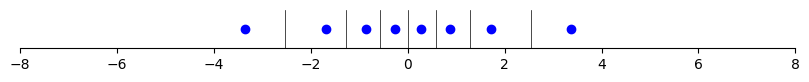

In [5]:
def kmeanspp_init(data: Tensor, n_codepoints: int) -> Tensor:
    """Initial centroids according to k-means++"""
    codepoints = torch.empty(n_codepoints, device=data.device, dtype=data.dtype)
    d2 = torch.ones_like(data)
    _idx = torch.empty(data.shape, dtype=torch.long)
    for i in range(n_codepoints):
        codepoints[i] = data[torch.multinomial(d2 / d2.sum(), 1)]
        torch.sort(codepoints[:i+1], out=(codepoints[:i+1], _idx[:i+1]))
        closest = torch.bucketize(data, (codepoints[:i] + codepoints[1:i+1]) / 2)
        d2 = (data - codepoints[closest]) ** 2
    return codepoints


def lloyd_max(data: Tensor, bits: Tensor, convergence_threshold: float = 1e-4) -> Quantiser:
    codepoints = kmeanspp_init(data, tensor(2.0).pow(bits).round().long().item())
    idx = torch.empty(data.shape, device=data.device, dtype=torch.int64)
    last_idx = torch.empty_like(idx)
    while True:
        last_idx[...] = idx
        thresholds = (codepoints[1:] + codepoints[:-1]) / 2
        torch.bucketize(data, thresholds, out=idx)
        codepoints.scatter_reduce_(0, idx, data, "mean", include_self=False)
        idx_change = (last_idx != idx).float().mean().item()
        if idx_change <= convergence_threshold:
            return Quantiser.fixed_length(codepoints)


q = lloyd_max(data, tensor(3))
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")
show(q).set_xlim((-8, 8));

### Entropy-coded Uniform

error = 0.144
 bits = 2.999


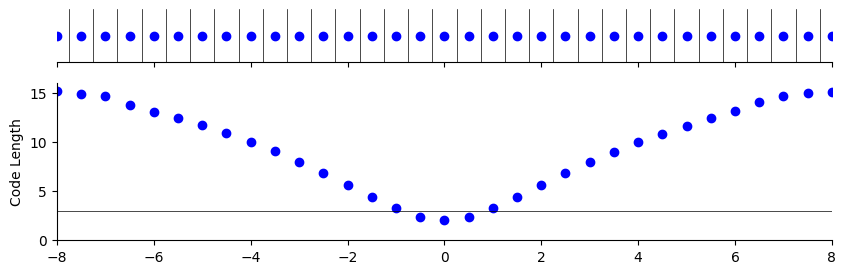

In [10]:
def entropy_uniform(data: Tensor, delta: float) -> Quantiser:
    codepoints = torch.arange(
        data.amin().div(delta).floor().long(),
        data.amax().div(delta).ceil().long() + 1,
    ).mul(delta)
    thresholds = (codepoints[:-1] + codepoints[1:]) / 2
    counts = torch.bucketize(data, thresholds).bincount(minlength=len(codepoints))
    lengths = counts.div(len(data)).log2().neg()
    return Quantiser(codepoints, thresholds, lengths)

q = entropy_uniform(data, 0.5)
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")

_, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 3), sharex=True, gridspec_kw=dict(height_ratios=[1, 3]))
show(q, ax0)
ax0.set_xlim((-8, 8))
counts = torch.bucketize(data, q.thresholds).bincount(minlength=len(q.codepoints))
ax1.scatter(q.codepoints.cpu(), counts.div(len(data)).log2().neg().cpu(), color="b")
ax1.set_xlim((-8, 8))
ax1.set_ylim((0, 16))
ax1.set_ylabel("Code Length")
ax1.axhline(3, color="k", lw=.5);

### Uniform Reconstruction Quantisation

error = 0.298
 bits = 1.933
  eff = 1.140


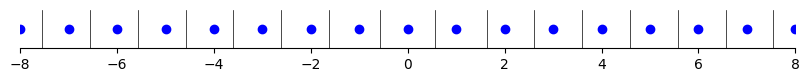

In [ ]:
def uniform_reconstruction_heuristic(data: Tensor, delta: float, lambda_ratio: float = 0.1, convergence_threshold: float = 1e-3) -> Quantiser:
    lam = lambda_ratio * delta ** 2  # this is the heuristic - depends on data distribution
    codepoints = torch.arange(
        data.amin().div(delta).floor().long(),
        data.amax().div(delta).ceil().long() + 1,
    ).mul(delta)
    # Optimise thresholds
    thresholds = (codepoints[:-1] + codepoints[1:]) / 2
    idx = None
    while True:
        idx, last_idx = torch.bucketize(data, thresholds), idx
        if last_idx is not None:
            idx_change = idx.ne(last_idx).float().mean().item()
            if idx_change < convergence_threshold:
                return Quantiser(codepoints, thresholds, lengths)
        counts = idx.bincount(minlength=len(codepoints)).add(1)
        lengths = counts.div(counts.sum()).log2().neg()
        thresholds = (
            (codepoints[:-1] + codepoints[1:]) / 2
            + lam * (lengths[1:] - lengths[:-1]) / delta / 2
        )

q = uniform_reconstruction_heuristic(data, 1)
error = rmse_norm(data, q)
bits = q.bits_per_element(data)
print(f"error = {error:.3f}")
print(f" bits = {bits:.3f}")
print(f"  eff = {error * tensor(2).pow(bits):.3f}")
show(q).set_xlim((-8, 8));

error = 0.246
 bits = 2.211
  eff = 1.140


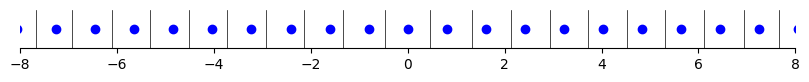

In [ ]:
# An attempt to implement the URQ from slide 35.
# This doesn't really make much sense. I suspect this is an incorrect mapping when using
# samples, as we shouldn't use `thresholds` at all, instead use explicit index assignments as does ECSQ.
# However this will break our Quantiser.quantise() logic, so we won't fix it here.
def uniform_reconstruction_attempt(data: Tensor, lam: float) -> Quantiser:
    delta = math.sqrt(lam)  # not a good estimate
    for _ in range(100):
        codepoint_idx = torch.arange(
            data.amin().div(delta).floor().long(),
            data.amax().div(delta).ceil().long() + 1,
        )
        codepoints = codepoint_idx.mul(delta)
        thresholds = (codepoints[:-1] + codepoints[1:]) / 2
        for _ in range(3):
            idx = torch.bucketize(data, thresholds)
            counts = idx.bincount(minlength=len(codepoints)).add(1)
            lengths = counts.div(counts.sum()).log2().neg()
            thresholds = (
                (codepoints[:-1] + codepoints[1:]) / 2
                + lam * (lengths[1:] - lengths[:-1]) / delta / 2
            )
        delta = (
            torch.zeros_like(codepoints).scatter_reduce_(0, idx, data, "sum").mul(codepoint_idx).sum()
            / counts.mul(codepoint_idx**2).sum()
        )
    return Quantiser(codepoints, thresholds, lengths)

q = uniform_reconstruction_attempt(data, 0.1)
error = rmse_norm(data, q)
bits = q.bits_per_element(data)
print(f"error = {error:.3f}")
print(f" bits = {bits:.3f}")
print(f"  eff = {error * tensor(2).pow(bits):.3f}")
show(q).set_xlim((-8, 8));

### Entropy Constrained Scalar Quantisation

    N = 31
error = 0.538
 bits = 1.031


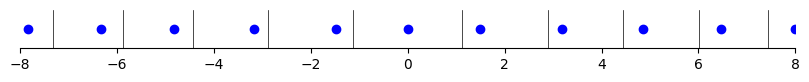

In [ ]:
def ecsq(data: Tensor, lam: float, convergence_threshold: float = 1e-3) -> Quantiser:
    delta = math.sqrt(lam * 0.5)  # heuristic - should be plenty
    codepoints = torch.arange(
        data.amin().div(delta).floor().long(),
        data.amax().div(delta).ceil().long() + 1,
    ).mul(delta)
    lengths = torch.ones_like(codepoints)
    idx = torch.zeros_like(data, dtype=torch.long)
    while True:
        last_idx = idx
        idx = (data[:, None] - codepoints).pow(2).add(lam * lengths).argmin(-1)
        codepoints.scatter_reduce_(0, idx, data, "mean", include_self=False)
        lengths = idx.bincount(minlength=len(codepoints)).div(len(data)).log2().neg()
        idx_change = (last_idx != idx).float().mean().item()
        if idx_change <= convergence_threshold:
            mask = ~torch.isinf(lengths)
            codepoints, lengths = codepoints[mask], lengths[mask]
            thresholds = (codepoints[1:] + codepoints[:-1]) / 2 + lam * (lengths[1:] - lengths[:-1]) / 2
            return Quantiser(codepoints, thresholds, lengths)

q = ecsq(data, 2**-1.8, 0)
print(f"    N = {len(q.codepoints)}")
print(f"error = {rmse_norm(data, q):.3f}")
print(f" bits = {q.bits_per_element(data):.3f}")
show(q).set_xlim((-8, 8));

### Evaluation

In [41]:
results = {
    "scaled-int": tradeoff(data, scaled_int, torch.linspace(1, 4, 7)),
    "lloyd-max": tradeoff(data, lloyd_max, torch.linspace(1, 4, 7)),
    "entropy-uniform": tradeoff(data, entropy_uniform, 2 ** torch.linspace(-2, 1.1, 7)),
    "urq-heuristic": tradeoff(data, uniform_reconstruction_heuristic, 2 ** torch.linspace(-2, 0.8, 7)),
    "ecsq": tradeoff(data, ecsq, 2 ** torch.linspace(-7, -1.8, 7)),
}

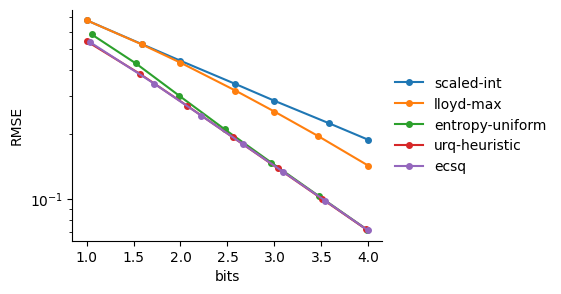

In [42]:
_, ax = plt.subplots()
for k, (bits, error) in results.items():
    ax.plot(bits, error, label=k, marker="o", ms=4)
ax.set_xlabel("bits")
ax.set_ylabel("RMSE")
ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

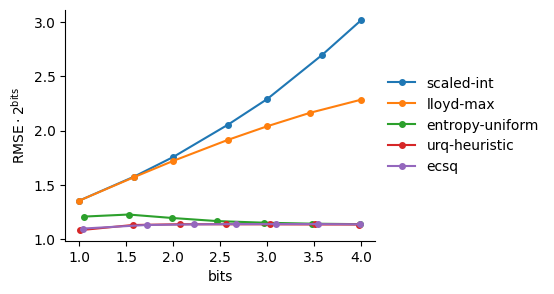

In [43]:
_, ax = plt.subplots()
for k, (bits, error) in results.items():
    ax.plot(bits, error * 2**bits, label=k, marker="o", ms=4)
ax.set_xlabel("bits")
ax.set_ylabel(r"$\mathrm{RMSE} \cdot 2^{\mathrm{bits}}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));